In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pyarrow.parquet as pq
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
import os

import plotly.graph_objects as go
from astropy.time import Time
from time import time
import json
from json import JSONEncoder

Lectura de Data set de paula

In [2]:
label_file = '../labeled_set_lc_classifier_SanchezSaez_2020.csv'
features_file = '../features_for_lc_classifier_20200609.csv'

# df con el evento (oid) y sus caracteristicas(183)
df_features = pd.read_csv(features_file)

# df con el evento(oid) y su clasificacion por ALeRCE
# df_labels = pd.read_csv(label_file)
df_labels = pd.read_csv(label_file,index_col='oid')



In [3]:
#Descarto valores infinitos
df_features = df_features.replace([np.inf, -np.inf], np.nan)

In [16]:
print('df_feautes: ', len(df_features))
print('df_labels: ',len(df_labels))


df_feautes:  868371
df_labels:  123496


In [4]:
print('cantidad de eventos etiquetados: ',df_labels['classALeRCE'].values.size)
# df_label.head()
print('-'*10)
print('cantidad de eventos:', len(df_features))
df_features.head()

cantidad de eventos etiquetados:  123496
----------
cantidad de eventos: 868371


,oid,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,...,W4,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2
0,ZTF17aaaaavn,0.106021,0.613572,0.078912,0.097860,0.847902,0.673712,2.0,1.0,0.380952,...,9.426,-0.301,1.491,4.239709,2.748709,5.350475,3.859475,1.110766,0.017990,4.895612e-01
1,ZTF17aaaadjh,0.233443,0.233454,0.493980,0.463765,1.000000,1.000000,1.0,1.0,0.279070,...,8.905,-0.125,2.380,4.533904,2.153904,5.281445,2.901445,0.747541,0.000011,5.197596e-08
2,ZTF17aaaadwo,0.060049,0.216873,0.090708,0.196542,0.903625,0.993806,1.0,1.0,0.368421,...,8.848,-0.065,1.602,4.344352,2.742352,5.495974,3.893974,1.151622,0.423044,2.662193e-01
3,ZTF17aaaajjv,526.315748,555.555529,0.539600,0.566276,1.000000,1.000000,14.0,20.0,0.419580,...,5.957,-0.040,0.997,7.765696,6.768696,10.193531,9.196531,2.427835,29.239637,1.437226e-04
4,ZTF17aaaakjt,0.148265,0.148265,0.564867,0.572449,0.999907,0.990501,1.0,1.0,0.338462,...,9.098,-0.027,0.027,3.161238,3.134238,4.298826,4.271826,1.137588,0.000002,2.169809e-06


In [5]:
# df con los datos de los eventos etiquetados
df_labels.head()

,classALeRCE,ra,dec,source,id_source
oid,,,,,
ZTF19aapcxhy,AGN,154.202.128.520.588,18.723.076.382.352.900,Oh2015,"5,88E+32"
ZTF18abtmwvo,AGN,4.607.405,47.421.185,Oh2015,"5,88E+32"
ZTF18acvgdfy,AGN,1.344.074.091.833.330,5.472.595.541.666.660,Oh2015,"5,88E+32"
ZTF19aabvjsi,AGN,13.235.329.823.749.900,140.672.658.875,Oh2015,"5,88E+32"
ZTF18aadyxlg,AGN,12.557.700.387,33.091.120.309.999.900,Oh2015,"5,88E+32"


In [6]:
#defining taxonomy tree according to the taxonomy presented in Section 2.2 of the paper.
df_labels['class_original'] = df_labels['classALeRCE']

#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)

# labels = labels.rename_axis(None,axis=0)
# labels = labels.set_axis('oid',axis=0)
print(len(labels))
labels = labels.reset_index()
labels.head()

(123496,)
123496


,oid,class_original,class_hierachical
0,ZTF19aapcxhy,AGN,Stochastic
1,ZTF18abtmwvo,AGN,Stochastic
2,ZTF18acvgdfy,AGN,Stochastic
3,ZTF19aabvjsi,AGN,Stochastic
4,ZTF18aadyxlg,AGN,Stochastic


In [7]:
labels = labels.set_axis(['oid','class_original', 'class_hierachical'],axis='columns')

In [8]:
for index, class_alerce in enumerate(label_order):
   print(index+1,class_alerce, labels['class_original'][labels['class_original']==class_alerce].shape[0])

1 SNIa 1272
2 SNIbc 94
3 SNII 328
4 SLSN 24
5 QSO 26168
6 AGN 4667
7 Blazar 1267
8 YSO 1740
9 CV/Nova 871
10 LPV 14076
11 E 37901
12 DSCT 732
13 RRL 32482
14 CEP 618
15 Periodic-Other 1256


Counter({'E': 37901, 'RRL': 32482, 'QSO': 26168, 'LPV': 14076, 'AGN': 4667, 'YSO': 1740, 'SNIa': 1272, 'Blazar': 1267, 'Periodic-Other': 1256, 'CV/Nova': 871, 'DSCT': 732, 'CEP': 618, 'SNII': 328, 'SNIbc': 94, 'SLSN': 24})
                number
E                37901
RRL              32482
QSO              26168
LPV              14076
AGN               4667
YSO               1740
SNIa              1272
Blazar            1267
Periodic-Other    1256
CV/Nova            871
DSCT               732
CEP                618
SNII               328
SNIbc               94
SLSN                24


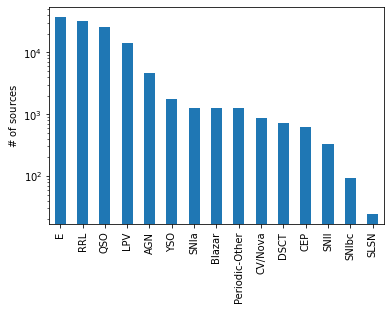

In [9]:
#plotting the number of sources per class for the labeled set
class_counts = Counter(labels['class_original'])
class_counts.most_common()
print(class_counts)
df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)

plt.yscale('log')
plt.ylabel(r'$\#$ of sources')
plt.savefig('number_sources_labeled_set.pdf',bbox_inches='tight')

-------------------------------------------------

Lectura de data set exp3


In [10]:
parquet_file = pq.ParquetFile('../lightcurves_ts.parquet')
print("numero de columnas:", parquet_file.metadata.num_columns)
print("numero de filas (datos): ", parquet_file.metadata.num_rows)

data = parquet_file.read_row_group(0, ['oid', 'fid', 'mjd', 'magpsf_corr', 'sigmapsf_corr', 'classALeRCE']).to_pandas()
all_event = data.oid.unique()
print('cantidad de eventos: ',len(all_event))
print('-'*10)

data.head()


numero de columnas: 113
numero de filas (datos):  13844917
cantidad de eventos:  173693
----------


,oid,fid,mjd,magpsf_corr,sigmapsf_corr,classALeRCE
0,ZTF17aaacfxu,1,58863.138021,20.996371,0.444790,RRL
1,ZTF17aaacfxu,1,58867.179803,19.374605,0.175861,RRL
2,ZTF17aaacfxu,1,58871.170336,19.630466,0.123111,RRL
3,ZTF17aaacfxu,1,58880.146204,19.362001,0.103466,RRL
4,ZTF17aaacfxu,1,58849.131389,19.530453,0.078387,RRL


In [11]:
# limpieza de datos 
df_data = data.replace([np.inf, -np.inf], np.nan)
df_data = df_data.dropna()

print(df_data['classALeRCE'].values.size)
df_data.head()

13697564


,oid,fid,mjd,magpsf_corr,sigmapsf_corr,classALeRCE
0,ZTF17aaacfxu,1,58863.138021,20.996371,0.444790,RRL
1,ZTF17aaacfxu,1,58867.179803,19.374605,0.175861,RRL
2,ZTF17aaacfxu,1,58871.170336,19.630466,0.123111,RRL
3,ZTF17aaacfxu,1,58880.146204,19.362001,0.103466,RRL
4,ZTF17aaacfxu,1,58849.131389,19.530453,0.078387,RRL


In [12]:
# muestra los eventos unicos, sin repeticiones
all_event = data.oid.unique()

print('eventos totales',all_event.shape)
print(all_event)

eventos totales (173693,)
['ZTF17aaacfxu' 'ZTF17aaaczwj' 'ZTF17aaaemke' ... 'ZTF20abgdwuf'
 'ZTF20abhagts' 'ZTF20abiqqow']


----------------

Obtiene un arreglo con los eventos que se comparten entre el data set del exp3 y el data set de caracteristicas (df_features)

In [17]:
len_all_event = len(all_event)
len_features = len(df_features)

init = 1
limit = 10

same_event = []
start_time = time()

# obtener arreglo con los nombres de los eventos que coinciden con ambos data set (paula y leo)
for i in range(init,len_all_event):
    event = df_features.loc[df_features['oid'] == all_event[i]]
    name_event = event['oid'].to_string(index=False)
    # print('event',event)
    # display(event)
    if(name_event != 'Series([], )'):
        same_event.append(name_event)
    if(i == limit):
        break

end_time = time() - start_time
print('tiempo: ',end_time)

tiempo:  0.30550432205200195


In [18]:
same_event

['ZTF17aaaemke',
 'ZTF17aaafyya',
 'ZTF17aaageae',
 'ZTF17aaaivsr',
 'ZTF17aaaizej',
 'ZTF17aaajizt',
 'ZTF17aaajlul',
 'ZTF17aaakstv',
 'ZTF17aaanxog']

In [139]:
import json
from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

same_event_json = {'name_event': same_event}

output = json.dumps(same_event_json, cls=NumpyArrayEncoder)

with open('same_event_group1.json', 'w') as outfile:
    outfile.write(output)

Lectura de archivos json que poseen eventos que se comparten en ambos data set

In [13]:
# primer grupo
with open('same_event_group0.json','r') as group0:
    firt_group = json.load(group0)

all_group = firt_group['name_event']
print('eventos iguales entre db paula y peña: ',len(firt_group['name_event']))


eventos iguales entre db paula y peña:  35603


In [14]:
# test
test = pd.DataFrame(firt_group['name_event'],columns=['oid'])
unique = test.oid.unique()
print(len(unique))
test.head()


35603


,oid
0,ZTF17aaaemke
1,ZTF17aaafyya
2,ZTF17aaageae
3,ZTF17aaaivsr
4,ZTF17aaaizej


De los eventos compartidos, verificar cuales de estos se comparten con el data set (labels) que poseen las clases de ALeRCE

In [18]:
limit = 1000
# all_group = firt_group

same_event = []

start_time = time()
for index, event in enumerate(all_group):
    # print(index,event)
    # labels es el df con los eventos y su clasificacion 
    test = labels.loc[labels['oid'] == event].values

    if(len(test) == 0):
        continue

    same_event.append(test[0])

    if(index == limit):
        break

end_time = time() - start_time
print(f'Tiempo: {end_time}')
same_event = np.array(same_event)
# print(same_event)

Tiempo: 5.506475210189819


In [19]:
# transformar a dataframe
df_same_event = pd.DataFrame(same_event,columns=['oid','class_original','class_hierachical'])
print('cantidad de eventos unicos:',len(df_same_event.oid.unique()))
df_same_event.head()

cantidad de eventos unicos: 999


,oid,class_original,class_hierachical
0,ZTF17aaaemke,E,Periodic
1,ZTF17aaafyya,E,Periodic
2,ZTF17aaageae,RRL,Periodic
3,ZTF17aaaivsr,E,Periodic
4,ZTF17aaaizej,RRL,Periodic


In [20]:
# guardar data frame en un csv con las columnas: oid, class_original, class_hierachical
df_same_event.to_csv('test_event.csv',index=False)

Cantidad de eventos que pertenecen a cada clase de ALeRCE

In [21]:
same_event = df_same_event.set_index('oid')
# same_event.head()

for index, class_alerce in enumerate(label_order):
   print(index+1,class_alerce, df_same_event['class_original'][df_same_event['class_original']==class_alerce].shape[0])


1 SNIa 14
2 SNIbc 0
3 SNII 2
4 SLSN 0
5 QSO 191
6 AGN 34
7 Blazar 10
8 YSO 18
9 CV/Nova 2
10 LPV 134
11 E 329
12 DSCT 7
13 RRL 240
14 CEP 2
15 Periodic-Other 16


Filtrado para ver los eventos que poseen datos en el filtro de banda g

In [22]:
# lectura archivo csv que guardamos anteriormente (eventos que se encuentran en ambos data set [paula y mio])
df_event = pd.read_csv('test_event.csv')
print('Cantidad de eventos filtrados: ',len(df_event))
df_event.head()

Cantidad de eventos filtrados:  999


,oid,class_original,class_hierachical
0,ZTF17aaaemke,E,Periodic
1,ZTF17aaafyya,E,Periodic
2,ZTF17aaageae,RRL,Periodic
3,ZTF17aaaivsr,E,Periodic
4,ZTF17aaaizej,RRL,Periodic


In [23]:
# obtenemos el data set del archivo parquet que contiene los datos del tiempo (mjd) y magnitud de las curvas de luz, este df tiene todos los puntos de cada evento como una unica fila
df_event_ts = data
all_event = df_event_ts.oid.unique()
print('cantidad de eventos: ',len(all_event))
print('-'*10)

df_event_ts.head()

cantidad de eventos:  173693
----------


,oid,fid,mjd,magpsf_corr,sigmapsf_corr,classALeRCE
0,ZTF17aaacfxu,1,58863.138021,20.996371,0.444790,RRL
1,ZTF17aaacfxu,1,58867.179803,19.374605,0.175861,RRL
2,ZTF17aaacfxu,1,58871.170336,19.630466,0.123111,RRL
3,ZTF17aaacfxu,1,58880.146204,19.362001,0.103466,RRL
4,ZTF17aaacfxu,1,58849.131389,19.530453,0.078387,RRL


Obtener un arreglo donde en cada indice se encuentran los datos de una curva de luz (del data set .parquet que tiene los datos del mjd y mag de los eventos)

In [ ]:
# se espera obtener un arreglo de la forma: [df evento 1, df evento 2, df evento 3, ... , df evento n]
# este proceso tiene un costo de tiempo de 0,4787 s aprox. 
df_data_unique = df_event_ts.oid.unique()
limit = 10
i = 0
all_time_serie = []

time_test = time()

for index, name_event in enumerate(df_data_unique):
    event = df_event_ts.loc[df_event_ts['oid'] == name_event].sort_values(by=['mjd'])
    rows_event, cols_event = event.shape

    if(rows_event == 1):
        continue

    all_time_serie.append(event)

    i = i + 1
    if i == limit:
        break
time_end = time() - time_test

print(f'time: {time_end}')
print(len(all_time_serie))
print(all_time_serie)
# encontrar la forma de guardar estos datos en un archivo aparte para no volver a realizarlo cada vez que se ejecuta el codigo

Funciones para la obtencion del tensor (método propuesto)

In [26]:
def getStatistic(index,indBin,magnitud, amount_bins):
    #Analisis en base a la magnitud
    mag_ordered = magnitud[index]
    
    #Obtención de vectores con caracteristicas estadisticas
    vector_mean = np.array([np.nanmean(mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000  for i in range(amount_bins)])
    vector_max = np.array([np.nanmax(mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000 for i in range(amount_bins)])
    vector_min = np.array([np.nanmin(mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000 for i in range(amount_bins)])
    vector_std = np.array([np.nanstd(mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000 for i in range(amount_bins)])

    return [vector_mean,vector_max,vector_min,vector_std]

    

def drawGraphic(bins,time,mag,indice,period):
    title_figure = f'Folded Time Serie with period T/{period}'
    #Grafico para ver la serie de tiempo 
    plt.figure(figsize=(12,4))
    plt.plot(time[indice], mag[indice])
    plt.scatter(time[indice], mag[indice])
    plt.ylabel("Magnitud")
    plt.xlabel("Time")
    plt.suptitle(title_figure, fontsize=22)
    plt.grid(axis='x', color='red', linestyle='-', linewidth=2)

    for bin in bins:
        plt.axvline(x=bin,color='red')
    # plt.grid(axis='y', color='gray', linestyle='dashed')
    plt.show()


def variantion_period_v2(array_periods,ts_time, ts_mag, amount_bins=10):
    tensor_data = []
    for period in array_periods:
        #valor del periodo en decimales
        period_float = 1 / period
        #proceso de folding
        folded_time = ts_time % period_float
        # print('folded_time',folded_time)

        #indices de los datos para encontrarlos luego del folding
        index_folded = np.argsort(folded_time)
        # print('index_folded',index_folded)

        #Divido el periodo en bins o intervalos [0,n] para luego obtener datos estadisticos de cada bin
        bins = np.linspace(0,period_float,amount_bins+1)
        #Concentración de datos en cada bin
        concentration, bin_edges= np.histogram(folded_time[index_folded],bins=bins)
        #indices - Devuelve los índices de los bins a los que pertenece cada valor del folded_time
        index_bin = np.digitize(folded_time[index_folded],bins=bins)

        # print("bins: ",bins)
        # print("concentracion de datos en cada bin: ",concentration)
        #Obtención de datos estadisticos de cada bin y formación del tensor
        vectorStatisticPeriod = np.asmatrix(getStatistic(index_folded,index_bin,ts_mag,amount_bins))
        tensor_data.append(vectorStatisticPeriod)

    return tensor_data

# funcion para graficar la serie de tiempo con link al sitio web de ALeRCE del evento
def GraphicLightCurve(fig,band,light_curve,show):
    mtcolor = [['g','green'],['r','red'],['b','blue']]
    idx=(light_curve['fid']==band).values
    fig.add_trace(
            go.Scatter(
                x = light_curve.mjd.values[idx],
                y = light_curve.magpsf_corr.values[idx],
                mode = 'markers', name=mtcolor[band-1][0],
                marker_color = mtcolor[band-1][1],
                error_y = dict(type='data', array=light_curve.sigmapsf_corr.values[idx], visible=True),
                marker = dict(size=10, opacity=0.5, showscale=False, line=dict(width=1)), 
                showlegend = True,
                legendgroup = mtcolor[band-1][0],
                hovertemplate ='<b>' + mtcolor[band-1][0] + ':\t\t</b>' + light_curve.magpsf_corr[idx].map('{:.3f}'.format).apply(str) + ' ± ' +
                                light_curve.sigmapsf_corr[idx].map('{:.3f}'.format).apply(str)  + '<br>' + 
                                '<b>MJD:\t</b>'+ light_curve.mjd[idx].apply(str)  + '<br>' + 
                                '<b>Date:\t</b>'+ [temp.strftime('%a, %d %b %Y %H:%M:%S UTC') for temp in Time(light_curve.mjd[idx].values, format='mjd').datetime]+ '<br>' +
                                '<extra></extra>'
                ))
    # fig['layout']['yaxis']['autorange'] = "reversed"
    fig.update_xaxes(
        tickangle=0,
        title_text="Modified Julian Dates [MJD]",
        title_font={"size": 14})
    
    fig.update_yaxes(
        autorange= 'reversed',
        tickangle=0,
        title_text="Magnitude [Mag]",
        title_font={"size": 14})
    
    fig.update_layout(
        title={'text':'<b>Light Curve</b>' + '<br>' +
                        '<a href="https://alerce.online/object/'+ event + '">Object: ' + event + 'text</a>',
                'font':dict(size=14),'x':0.5, 'y':0.9,'xanchor': 'center','yanchor': 'top'})
    
    if_show_fig = lambda show: fig.show() if show == True else False
    if_show_fig(show)

Obtener tensor con caracteristicas

In [27]:
# ----------------------------
limit_event = 5
num_periods = 4
nbines = 10
array_periods = 2**(np.arange(num_periods)+0)

tensor_all_event = {}

time_arr = []
# ----------------------------

main_start = time()

for index, event in enumerate(all_time_serie):
    event_start = time()
    # obtiene el nombre del evento
    name_unique = event.oid.unique()
    tensor_band = {}

    # obtener solo los del filtro de banda 1 (g)
    event_band = event.loc[event['fid'] == 1].sort_values(by=['mjd'])
    # print(event_band)
        
    if(event_band.empty is False):
        rows, cols = event_band.shape

        if(rows == 1):
            break

        # normalized
        min_mjd = event_band['mjd'].values.min()
        max_mjd = event_band['mjd'].values.max()
        time_normalized = (event_band['mjd'].values - min_mjd)/(max_mjd - min_mjd)

        # tensor con caracteristicas de cada filtro
        tensor = np.array(variantion_period_v2(array_periods, time_normalized, event_band['magpsf_corr'].values, nbines))
        # tensor de cada banda
        tensor_band[f'g band'] = tensor
    
    # asigna el tensor de cada filtro al evento
    tensor_all_event[f'{name_unique[0]}'] = tensor_band
    event_time = time() - event_start
    time_arr.append(event_time)

    if index == limit_event:
        break

print('-'*100)
main_time = time() - main_start
print(f'Time total: {main_time}')
print(f'Total event: {limit_event}')

print(f'Tiempo promedio por cada evento: {np.mean(time_arr)}')
# print(dict_all_tensor)



----------------------------------------------------------------------------------------------------
Time total: 0.05260181427001953
Total event: 10
Tiempo promedio por cada evento: 0.005260181427001953


C:\Users\Leonardo Peña\AppData\Local\Temp\ipykernel_13888\39755260.py:6: RuntimeWarning: Mean of empty slice
  vector_mean = np.array([np.nanmean(mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000  for i in range(amount_bins)])
C:\Users\Leonardo Peña\AppData\Local\Temp\ipykernel_13888\39755260.py:7: RuntimeWarning: All-NaN slice encountered
  vector_max = np.array([np.nanmax(mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000 for i in range(amount_bins)])
C:\Users\Leonardo Peña\AppData\Local\Temp\ipykernel_13888\39755260.py:8: RuntimeWarning: All-NaN slice encountered
  vector_min = np.array([np.nanmin(mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000 for i in range(amount_bins)])
c:\Users\Leonardo Peña\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [31]:
tensor_all_event

{'ZTF17aaacfxu': {'g band': array([[[ 1.94462269e+01, -1.00000000e+03, -1.00000000e+03,
           -1.00000000e+03,  2.09963713e+01,  1.93746046e+01,
           -1.00000000e+03,  1.96304659e+01, -1.00000000e+03,
           -1.00000000e+03],
          [ 1.95304530e+01, -1.00000000e+03, -1.00000000e+03,
           -1.00000000e+03,  2.09963713e+01,  1.93746046e+01,
           -1.00000000e+03,  1.96304659e+01, -1.00000000e+03,
           -1.00000000e+03],
          [ 1.93620007e+01, -1.00000000e+03, -1.00000000e+03,
           -1.00000000e+03,  2.09963713e+01,  1.93746046e+01,
           -1.00000000e+03,  1.96304659e+01, -1.00000000e+03,
           -1.00000000e+03],
          [ 8.42261630e-02, -1.00000000e+03, -1.00000000e+03,
           -1.00000000e+03,  0.00000000e+00,  0.00000000e+00,
           -1.00000000e+03,  0.00000000e+00, -1.00000000e+03,
           -1.00000000e+03]],
  
         [[ 1.94462269e+01,  1.93746046e+01, -1.00000000e+03,
           -1.00000000e+03,  1.96304659e+01, -1.

Agregar el tensor al df_features correspondiente

In [41]:
df_features.loc[df_features.oid == 'ZTF17aaacfxu']

,oid,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,...,W4,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2


In [40]:
limit_event = 5


for index, event in enumerate(tensor_all_event):
     print(event)
     event_features = df_features.loc[df_features['oid'] == event]
     # print(event_features)
     # event_features.head()
     display(event_features)

     if(index == limit_event):
          break


ZTF17aaacfxu


,oid,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,...,W4,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2


ZTF17aaaemke


,oid,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,...,W4,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2
356171,ZTF17aaaemke,0.135942,0.13594,0.319945,0.266913,0.999845,0.999997,1.0,1.0,0.361111,...,8.453,-0.025,1.044,3.225166,2.181166,4.193614,3.149614,0.968448,0.000002,4.405883e-08


ZTF17aaafyya


,oid,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,...,W4,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2
80499,ZTF17aaafyya,0.151124,0.151126,0.376849,0.347666,1.0,1.0,1.0,1.0,0.421875,...,8.889,-0.046,0.244,2.550194,2.306194,3.454954,3.210954,0.90476,0.000002,3.267149e-08


ZTF17aaageae


,oid,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,...,W4,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2
367823,ZTF17aaageae,0.818733,0.818867,0.218249,0.327319,1.0,0.999997,1.0,1.0,0.4,...,8.496,0.023,0.629,1.937573,1.308573,2.133469,1.504469,0.195896,0.000067,0.000067


ZTF17aaaivsr


,oid,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,...,W4,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2
498283,ZTF17aaaivsr,0.134073,0.134073,0.344626,0.30527,0.999993,0.821926,1.0,1.0,0.384615,...,8.573,-0.06,1.885,4.006276,2.121276,4.565984,2.680984,0.559708,0.000002,0.000002


ZTF17aaaizej


,oid,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,...,W4,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,g-r_ml,delta_period_1,delta_period_2
859841,ZTF17aaaizej,0.591017,0.590947,0.660175,0.404425,1.0,1.0,1.0,1.0,0.317073,...,8.406,0.009,2.871,4.185692,1.314692,4.359793,1.488793,0.1741,4.163987e-08,0.00007


In [38]:
import json
from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

output = json.dumps(tensor_all_event, cls=NumpyArrayEncoder)

with open('testt.json', 'w') as outfile:
    outfile.write(output)

-------------------